Dataset: https://github.com/mdeff/fma fma_medium and fma_metadata

# Imports

In [ ]:
# import the necessary packages
import os
from os import path
import sys
import math
import ast
import itertools

# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

# import the necessary packages
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
import IPython.display as ipd


# import the necessary packages
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from datetime import datetime
from PIL import Image, ImageOps

In [ ]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# specify the batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 100
EPOCHS_MLP = 50

# define the path to the base output directory
BASE_OUTPUT = ""
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# Aux functions

In [ ]:
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["f1_m"], label="train_f1")
	plt.plot(H.history["val_f1_m"], label="val_f1")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/F1")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def get_recommendation(model, target, data, rec_number, printable=True):
  recommended_list = []

  origA = target.copy()
  target = np.expand_dims(target, axis=0)

  if len(origA.shape) == 3 and origA.shape[-1] == 1:
      origA = origA[:, :, 0]

  if len(origA.shape) == 4 and origA.shape[-1] == 1:
      origA = origA[:, :, :, 0]

  index = 0
  for img in data:
    # load both the images and convert them to grayscale
    # create a copy of both the images for visualization purpose
    
    origB = img.copy()

    if len(origB.shape) == 3 and origB.shape[-1] == 1:
      origB = origB[:, :, 0]

    if len(origB.shape) == 4 and origB.shape[-1] == 1:
      origB = origB[:, :, :, 0]
    
    
    img = np.expand_dims(img, axis=0)
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    preds = model.predict([target, img], verbose = 0)
    proba = preds[0][0]

    recommended_list.append((origB, proba, index))
    index = index + 1
  
  # Queremos los mejores resultados
  if model.loss == "binary_crossentropy":
    # Better greater similarity
    recommended_list.sort(key=lambda a: a[1], reverse=True)
  else: 
    # Better less distance
    recommended_list.sort(key=lambda a: a[1])

  count = 0
  recommended_list_index = []
  for (rec_img, rec_pred, aux_index) in recommended_list:
    if count == rec_number:
      break
    # get the index of the recommended item in original list
    recommended_list_index.append(aux_index)

    if printable:
      # initialize the figure
      fig = plt.figure("Recommendations", figsize=(4, 2))
      if model.loss == "binary_crossentropy":
        plt.suptitle("Similarity: {:.2f}".format(rec_pred))
      else:
        plt.suptitle("Distance: {:.2f}".format(rec_pred))
      # show first image
      ax = fig.add_subplot(1, 2, 1)
      plt.imshow(origA)
      plt.axis("off")
      # show the second image
      ax = fig.add_subplot(1, 2, 2)
      plt.imshow(rec_img)
      plt.axis("off")
      # show the plot
      plt.show()
    count += 1

  return recommended_list_index

In [ ]:
def recall_and_precission_at_k(model, images, labels, k, p_groups=0.05, seed=42):
  random.seed(seed)
  n_items = len(images)

  np.array(images)
  images = images / 255.0
  images = np.expand_dims(images, axis=-1)

  items_index = random.sample(range(1, n_items), int(n_items*p_groups))
  
  sum_recall_list = []
  sum_precission_list = []

  for index in items_index:
    # The data retrieved is not given to de the net
    target = images[index]
    target_label = labels[index]
    data = np.concatenate((images[:index], images[index+1:]), axis=0)
    data_labels = np.concatenate((labels[:index], labels[index+1:]), axis=0)

    # Get top recommendations
    top_index = get_recommendation(model, target, data, k, printable=False)
    top_labels = np.ravel(data_labels[top_index]).tolist()

    # Compute Rel@k/Rel
    # Si coincide más de un genero es relevante * num de géneros que coincida
    data_labels = np.ravel(data_labels).tolist()
    rel = 0
    for i in target_label:
      if i != "-1":
        rel += data_labels.count(i)

    rel_at_k = 0
    for i in target_label:
      if i != "-1":
        rel_at_k += top_labels.count(i)
    sum_recall_list.append(rel_at_k / rel)

    # Compute Rel@k/k
    sum_precission_list.append(rel_at_k / k)

  return sum(sum_recall_list) / len(sum_recall_list), sum(sum_precission_list) / len(sum_precission_list)

# Load images

In [ ]:
!unzip precalculated_files_mel.zip

Archive:  precalculated_files_mel.zip
   creating: content/precalculated_files_mel/
   creating: content/precalculated_files_mel/DEADBEEF/
  inflating: content/precalculated_files_mel/DEADBEEF/107029.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107050.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107027.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107505.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107532.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107435.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107504.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107656.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107957.png  
  inflating: content/precalculated_files_mel/DEADBEEF/108031.png  
  inflating: content/precalculated_files_mel/DEADBEEF/108053.png  
  inflating: content/precalculated_files_mel/DEADBEEF/108474.png  
  inflating: content/precalculated_files_mel/DEADBEEF/107

# Load Metadata

In [ ]:
!unzip fma_metadata.zip

Archive:  fma_metadata.zip
  inflating: fma_metadata/tracks.csv  


In [ ]:
tracks_filepath = "fma_metadata/tracks.csv"

tracks = pd.read_csv(tracks_filepath, index_col=0, header=[0, 1])

In [ ]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
10,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN
20,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [ ]:
# We get only genre and track_id
track_genres_df = tracks['track'][["genres"]]

In [ ]:
del(tracks)

In [ ]:
track_genres_df

,genres
track_id,
2,[21]
3,[21]
5,[21]
10,[10]
20,"[76, 103]"
...,...
155316,[25]
155317,[25]
155318,[25]


In [ ]:
track_genres_df['genres'].value_counts()

[21]                    2735
[15]                    2689
[]                      2231
[12]                    1896
[1, 30, 38, 41, 247]    1633
                        ... 
[12, 542]                  1
[92, 602]                  1
[102, 189]                 1
[14, 30, 92]               1
[10, 12, 169]              1
Name: genres, Length: 4768, dtype: int64

# Tracks list

In [ ]:
path_to_files = 'content/precalculated_files_mel/DEADBEEF/'
files = list(os.listdir(path_to_files))

tracks_list = [int(os.path.splitext(x)[0]) for x in files]

In [ ]:
track_genres_df.loc[track_genres_df.index.isin(tracks_list)]

,genres
track_id,
105819,"[15, 297, 468]"
105820,"[15, 297, 468]"
105821,"[15, 297, 468]"
105822,"[15, 297, 468]"
105823,"[15, 297, 468]"
...,...
108883,"[18, 1235]"
108884,"[18, 1235]"
108885,"[18, 1235]"


# Match image and genre

In [ ]:
def stack_padding(l):
  return np.column_stack((itertools.zip_longest(*l, fillvalue=-1)))

In [ ]:
def get_pairs_route(images_dir, data_df, image_shape):
  images = []
  labels = []
  # names = []
  
  for i in os.listdir(images_dir):
    aux_label = data_df[data_df.index==int(os.path.splitext(i)[0])].genres.item()
    label = aux_label[1:-1].replace(" ", "").split(",")

    # load the image
    image = Image.open(images_dir+"/"+i)

    # All images should be same size
    image_resize = image.resize((image_shape[0], image_shape[0]))
    if(image_shape[2] == 1):
      channel_img = image_resize.convert("L")
    elif(image_shape[2] == 3):
      channel_img = image_resize.convert("RGB")
		
    # convert image to numpy array
    data = np.asarray(channel_img)
    
    images.append(data)
    labels.append(label)
    # names.append(i)

  return np.stack(images), stack_padding(labels)

In [ ]:
images, labels = get_pairs_route(path_to_files, track_genres_df, IMG_SHAPE)

<ipython-input-19-ee1dc2387759>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.column_stack((itertools.zip_longest(*l, fillvalue=-1)))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

In [ ]:
aux = 0
for i in X_train:
  assert i.shape == IMG_SHAPE, f"Shape expected {IMG_SHAPE} but {i.shape} was get. File n {aux}"
  aux+=1

In [ ]:
aux = 0
for i in images:
  assert i.shape == IMG_SHAPE, f"Shape expected {IMG_SHAPE} but {i.shape} was get. File n {aux}"
  aux+=1

# Create pairs

In [ ]:
def make_pairs(images, labels, seed=42):
  np.random.seed(seed)
  # initialize two empty lists to hold the (image, image) pairs and
  # labels to indicate if a pair is positive or negative
  pairImages = []
  pairLabels = []
  # calculate the total number of classes present in the dataset
  # and then build a list of indexes for each class label that
  # provides the indexes for all examples with a given label
  
  classes = np.unique(labels)
  index = np.argwhere(classes == "-1")
  classes = np.delete(classes, index)

  all_list = [*range(len(images))]

  idx = []
  for i in classes:
    aux = np.where(labels == i)[0]
    idx.append(aux)

  # loop over all images
  for idxA in range(len(images)):
    # grab the current image and label belonging to the current
    currentImage = images[idxA]
    label = labels[idxA]

    index = np.argwhere(label == "-1")
    label = np.delete(label, index)

    idxB_list = []

    for i in label:
      aux = np.where(classes == i)[0][0]
      idxB_list.append(idx[aux])

    idxB_list = np.concatenate(idxB_list)
    idxB_list = list(set(idxB_list))
    # randomly pick an image that belongs to the *same* class

    idxB = np.random.choice(idxB_list)
    posImage = images[idxB]
    
    # prepare a positive pair and update the images and labels
    # lists, respectively
    pairImages.append([currentImage, posImage])
    pairLabels.append([1])
    
    # grab the indices for each of the class labels *not* equal to
    # the current label and randomly pick an image corresponding
    # to a label *not* equal to the current label
    
    negIdx_list = []
    for idx_aux in all_list:
      if idx_aux not in idxB_list and idx != idxA:
        negIdx_list.append(idx_aux)

    del(idxB_list)
    negIdx = np.random.choice(negIdx_list)
    negImage = images[negIdx]
    del(negIdx)
    
    # prepare a negative pair of images and update our lists
    pairImages.append([currentImage, negImage])
    pairLabels.append([0])
  # return a 2-tuple of our image pairs and labels
  return (np.array(pairImages), np.array(pairLabels))

In [ ]:
(trainX, trainY), (testX, testY) = (np.array(X_train), np.array(y_train)), (np.array(X_test), np.array(y_test))
trainX = trainX / 255.0
testX = testX / 255.0
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

# Siamese Mnist

In [ ]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
 
	# define the first set of CONV => RELU => POOL => DROPOUT layers
  # 64 filters 2x2
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs) # Si entrada 28x28x1 -> 28x28x64
	x = MaxPooling2D(pool_size=2)(x) # Si entrada 28x28x64 -> 14x14x64
	x = Dropout(0.3)(x)
 
	# second set of CONV => RELU => POOL => DROPOUT layers
  # 64 filters 2x2
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x) # Si entrada 14x14x64 -> 14x14x64
	x = MaxPooling2D(pool_size=2)(x) # Si entrada 14x14x64 -> 7x7x64
	x = Dropout(0.3)(x)
 
 	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

## Data

In [ ]:
# configure the siamese network

# Why don't call build_siamese_model twice
# There are two sister networks, but implement them as a single instance

print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


## BCE

### Model

In [ ]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model_bce = Model(inputs=[imgA, imgB], outputs=outputs)

# Save best model epoch to disk
filepath = 'model_bce.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


callbacks = [checkpoint, es]
# compile the model

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_bce.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_bce.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5000 - f1_m: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.69040, saving model to model_bce.epoch01-loss0.69.hdf5
26/26 [==============================] - 16s 229ms/step - loss: 0.6912 - accuracy: 0.5000 - f1_m: 0.0000e+00 - val_loss: 0.6904 - val_accuracy: 0.5057 - val_f1_m: 0.0597
Epoch 2/100
25/26 [===========================>..] - ETA: 0s - loss: 0.6893 - accuracy: 0.4975 - f1_m: 0.0000e+00
Epoch 2: val_loss improved from 0.69040 to 0.68807, saving model to model_bce.epoch02-loss0.69.hdf5
26/26 [==============================] - 4s 167ms/step - loss: 0.6892 - accuracy: 0.5000 - f1_m: 0.0000e+00 - val_loss: 0.6881 - val_accuracy: 0.4885 - val_f1_m: 0.0668
Epoch 3/100
25/26 [===========================>..] - ETA: 0s - loss: 0.6885 - accuracy: 0.5038 - f1_m: 0.0127
Epoch 3: val_loss improved from 0.68807 to 0.68780, saving model to model_bc

### Graph

[INFO] plotting training history...


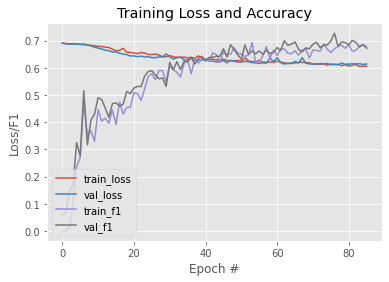

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Recall@k y Precision@k

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_bce, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission)

0.07635578879474583 0.2607142857142857


## CL

### Model

In [ ]:
distance = Lambda(euclidean_distance)([featsA, featsB])
model_cl = Model(inputs=[imgA, imgB], outputs=distance)

# Save best model epoch to disk
filepath = 'model_cl.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]
# compile the model
# compile the model


print("[INFO] compiling model...")
model_cl.compile(loss=contrastive_loss, optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_cl.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
25/26 [===========================>..] - ETA: 0s - loss: 3.0315 - accuracy: 0.4125 - f1_m: 0.5512
Epoch 1: val_loss improved from inf to 1.29614, saving model to model_cl.epoch01-loss1.30.hdf5
26/26 [==============================] - 6s 207ms/step - loss: 3.0149 - accuracy: 0.4107 - f1_m: 0.5409 - val_loss: 1.2961 - val_accuracy: 0.3391 - val_f1_m: 0.4375
Epoch 2/100
25/26 [===========================>..] - ETA: 0s - loss: 1.0123 - accuracy: 0.4263 - f1_m: 0.4853
Epoch 2: val_loss improved from 1.29614 to 0.66051, saving model to model_cl.epoch02-loss0.66.hdf5
26/26 [==============================] - 4s 166ms/step - loss: 1.0119 - accuracy: 0.4268 - f1_m: 0.4886 - val_loss: 0.6605 - val_accuracy: 0.3534 - val_f1_m: 0.3592
Epoch 3/100
25/26 [===========================>..] - ETA: 0s - loss: 0.5844 - accuracy: 0.4350 - f1_m: 0.4321
Epoch 3: val_loss improved from 0.66051 to 0.45275, saving model to model_cl.epoch03-loss0.45.h

### Graph

[INFO] plotting training history...


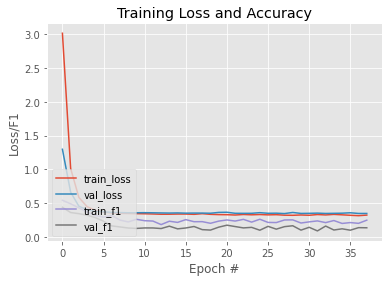

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Recall@k y Precision@k

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_cl, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission)

0.055153354408768375 0.3000000000000001


# VGG19

In [ ]:
def build_vgc19(inputShape, embeddingDim=48):
  base_model = VGG19(weights='imagenet', input_shape=inputShape, include_top=False, pooling=None)
  base_model.trainable = False

  inputs = Input(inputShape)
  x = base_model(inputs, training=False)

  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)

  # build the model
  model = Model(inputs, outputs)

  # return the model to the calling function
  return model

## Data

In [ ]:
# configure the siamese network

# Why don't call build_siamese_model twice
# There are two sister networks, but implement them as a single instance

print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_vgc19(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

## BCE

### Model

In [ ]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model_vgg_bce = Model(inputs=[imgA, imgB], outputs=outputs)

# Save best model epoch to disk
filepath = 'model_vgg_bce.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_vgg_bce.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_vgg_bce.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
  callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.4801 - f1_m: 0.6445
Epoch 1: val_loss improved from inf to 0.70717, saving model to model_vgg_bce.epoch01-loss0.71.hdf5
26/26 [==============================] - 26s 792ms/step - loss: 0.7148 - accuracy: 0.4801 - f1_m: 0.6445 - val_loss: 0.7072 - val_accuracy: 0.4425 - val_f1_m: 0.6131
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.4801 - f1_m: 0.6394
Epoch 2: val_loss improved from 0.70717 to 0.70261, saving model to model_vgg_bce.epoch02-loss0.70.hdf5
26/26 [==============================] - 13s 505ms/step - loss: 0.7013 - accuracy: 0.4801 - f1_m: 0.6394 - val_loss: 0.7026 - val_accuracy: 0.4425 - val_f1_m: 0.6131
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.4801 - f1_m: 0.6411
Epoch 3: val_loss improved from 0.70261 to 0.70114, saving model to model_vgg_bce.e

### Graph

[INFO] plotting training history...


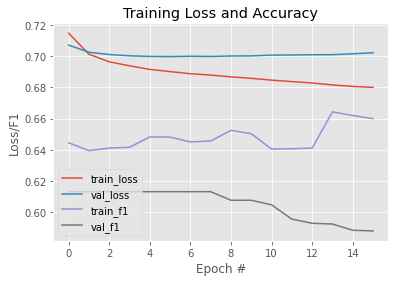

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Recall@k y Precision@k

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_vgg_bce, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission)

0.013007315182728008 0.11071428571428572


## CL

### Model

In [ ]:
distance = Lambda(euclidean_distance)([featsA, featsB])
model_vgg_cl = Model(inputs=[imgA, imgB], outputs=distance)

# Save best model epoch to disk
filepath = 'model_vgg_cl.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]
# compile the model

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_vgg_cl.compile(loss=contrastive_loss, optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_vgg_cl.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.4119 - f1_m: 0.4791
Epoch 1: val_loss improved from inf to 0.30791, saving model to model_vgg_cl.epoch01-loss0.31.hdf5
26/26 [==============================] - 33s 775ms/step - loss: 0.3440 - accuracy: 0.4119 - f1_m: 0.4791 - val_loss: 0.3079 - val_accuracy: 0.4770 - val_f1_m: 0.3694
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.5050 - f1_m: 0.4462
Epoch 2: val_loss improved from 0.30791 to 0.30405, saving model to model_vgg_cl.epoch02-loss0.30.hdf5
26/26 [==============================] - 13s 517ms/step - loss: 0.2785 - accuracy: 0.5050 - f1_m: 0.4462 - val_loss: 0.3040 - val_accuracy: 0.4741 - val_f1_m: 0.3447
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.5509 - f1_m: 0.4924
Epoch 3: val_loss improved from 0.30405 to 0.30341, saving model to model_vgg_cl.epoc

### Graph

[INFO] plotting training history...


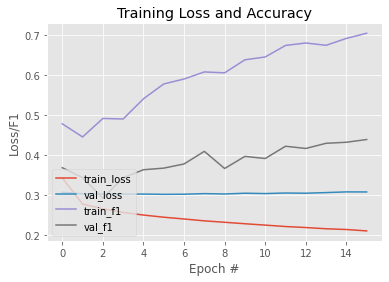

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Recall@k y Precision@k

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_vgg_cl, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission) 

0.024425790349518334 0.1892857142857143


# Inception-Resnet-V2

In [ ]:
def build_IRNV2(inputShape, embeddingDim=48):
  base_model = InceptionResNetV2(weights='imagenet', input_shape=inputShape, include_top=False, pooling=None)
  base_model.trainable = False

  inputs = Input(inputShape)
  x = base_model(inputs, training=False)

  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)

  # build the model
  model = Model(inputs, outputs)

  # return the model to the calling function
  return model

## Data

In [ ]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_IRNV2(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


## BCE

### Model

In [ ]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model_irnv2_bce = Model(inputs=[imgA, imgB], outputs=outputs)

# Save best model epoch to disk
filepath = 'model_irnv2_bce.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_irnv2_bce.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_irnv2_bce.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
  callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.4826 - f1_m: 0.6468
Epoch 1: val_loss improved from inf to 0.99759, saving model to model_irnv2_bce.epoch01-loss1.00.hdf5
26/26 [==============================] - 50s 876ms/step - loss: 1.1582 - accuracy: 0.4826 - f1_m: 0.6468 - val_loss: 0.9976 - val_accuracy: 0.4425 - val_f1_m: 0.6131
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.4801 - f1_m: 0.6457
Epoch 2: val_loss improved from 0.99759 to 0.91730, saving model to model_irnv2_bce.epoch02-loss0.92.hdf5
26/26 [==============================] - 15s 572ms/step - loss: 0.8857 - accuracy: 0.4801 - f1_m: 0.6457 - val_loss: 0.9173 - val_accuracy: 0.4425 - val_f1_m: 0.6131
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.8104 - accuracy: 0.4801 - f1_m: 0.6397
Epoch 3: val_loss improved from 0.91730 to 0.89402, saving model to model_irnv2

### Graph

[INFO] plotting training history...


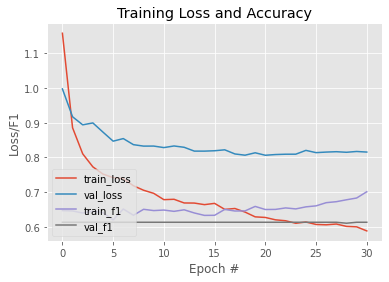

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Recall@k y Precision@k

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_irnv2_bce, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission) 

0.02677987802164878 0.20714285714285713


## CL

### Model

In [ ]:
distance = Lambda(euclidean_distance)([featsA, featsB])
model_irnv2_cl = Model(inputs=[imgA, imgB], outputs=distance)

# Save best model epoch to disk
filepath = 'model_irnv2_cl.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]
# compile the model

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_irnv2_cl.compile(loss=contrastive_loss, optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_irnv2_cl.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 2.5657 - accuracy: 0.4801 - f1_m: 0.6219
Epoch 1: val_loss improved from inf to 1.49864, saving model to model_irnv2_cl.epoch01-loss1.50.hdf5
26/26 [==============================] - 39s 821ms/step - loss: 2.5657 - accuracy: 0.4801 - f1_m: 0.6219 - val_loss: 1.4986 - val_accuracy: 0.4425 - val_f1_m: 0.6131
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.9300 - accuracy: 0.4801 - f1_m: 0.6402
Epoch 2: val_loss improved from 1.49864 to 1.09761, saving model to model_irnv2_cl.epoch02-loss1.10.hdf5
26/26 [==============================] - 16s 621ms/step - loss: 0.9300 - accuracy: 0.4801 - f1_m: 0.6402 - val_loss: 1.0976 - val_accuracy: 0.4425 - val_f1_m: 0.6131
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.4801 - f1_m: 0.6237
Epoch 3: val_loss improved from 1.09761 to 0.91631, saving model to model_irnv2_c

### Graph

[INFO] plotting training history...


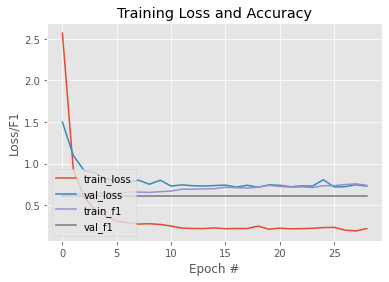

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Recall@k y Precision@k

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_irnv2_cl, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission) 

0.026893532881976927 0.14285714285714285
